# 基础

参考：[Practical Quantization in PyTorch](https://pytorch.org/blog/quantization-in-practice/)

{guilabel}`NN 量化目标`：运行更快、内存需求更低。

- 量化源于信息压缩；在深度神经网络中，它指的是降低其权重和/或激活的数值精度。
- 过度参数化的 DNN 有更多的 **自由度**，这使它们成为信息压缩的良好候选对象 {cite:ps}`gholami2021survey`。

当量化模型时，通常会发生两件事——模型变得更小，运行效率更高。硬件供应商明确地允许更快地处理 8 位数据（而不是 32 位数据），从而获得更高的 **吞吐量** （throughput）。更小的模型具有更低的内存占用和功耗 {cite:ps}`krishnamoorthi2018quantizing`，这对于边缘部署至关重要。

## 映射函数

映射函数：将值从浮点数映射到整数空间的函数。常用的映射函数是由 $Q(r) = round(r/S + Z)$ 给出的线性变换，其中为 $r$ 为输入，$S, Z$ 为量化参数（quantization parameters）。为了重新转换为浮点空间，反函数由 $\overline{r} = (Q(r) - Z) \cdot S$ 给出（被称为 **反量化**，即 dequantization）。

```{note}
$\overline{r} \neq r$，它们之间的差异构成了量化误差。
```

## 量化参数

映射函数由缩放因子 $S$ 和零点 $Z$ 所参数化。$S$ 仅仅是输入范围与输出范围的比值 $S = \frac {\beta - \alpha}{\beta_q - \alpha_q}$。这里 $[\alpha, \beta]$ 是输入的裁剪（clipping）范围，即允许输入的边界。$[\alpha_q, \beta_q]$ 是它被映射到的量化输出空间的范围。对于 8 位量化，输出范围 $\beta_q - \alpha_q \leq 2^8 -1$。$Z = -(\frac {\alpha}{S} - \alpha_q)$ 作为偏置，以确保输入空间中的 $0$ 完全映射到量化空间中的 $0$。

## 校准

选择输入裁剪范围的过程称为 **校准** （calibration）。最简单的方法（也是 PyTorch 中的默认方法）是记录正在运行的最小值和最大值，并将它们赋值给 $\alpha$ 和 $\beta$。[TensorRT](https://docs.nvidia.com/deeplearning/tensorrt/pytorch-quantization-toolkit/docs/calib.html) 也使用熵最小化（KL 散度），均方误差最小化，或输入范围的百分位数。

在 PyTorch 中，{class}`Observer <torch.ao.quantization.observer.ObserverBase>` 模块收集关于输入值的统计信息并计算 qparams $S,Z$。不同的校准方案会产生不同的量化输出，最好通过经验验证哪种方案最适合您的应用程序和体系结构。

In [1]:
import torch
from torch.ao.quantization.observer import MinMaxObserver, MovingAverageMinMaxObserver, HistogramObserver

# 设置输入
C, L = 3, 2
normal = torch.distributions.normal.Normal(0, 1)

inputs = [normal.sample((C, L)),
          normal.sample((C, L))]
inputs

[tensor([[-0.6123,  0.1598],
         [ 0.4631, -0.1487],
         [-0.1753,  1.1975]]),
 tensor([[-2.1246,  1.5558],
         [-0.8172,  0.5080],
         [ 0.3117, -0.8401]])]

设置观测：

In [2]:
observers = [MinMaxObserver(), 
             MovingAverageMinMaxObserver(),
             HistogramObserver()]

计算并查看量化参数：

In [3]:
for obs in observers:
    for x in inputs: obs(x)
    print(obs.__class__.__name__, obs.calculate_qparams())

MinMaxObserver (tensor([0.0144]), tensor([147], dtype=torch.int32))
MovingAverageMinMaxObserver (tensor([0.0072]), tensor([88], dtype=torch.int32))
HistogramObserver (tensor([0.0089]), tensor([79], dtype=torch.int32))


## 仿射和对称量化方案

仿射（affine）或非对称量化（asymmetric quantization）方案分配输入范围的最小和最大观测值。仿射方案通常提供更小的剪切范围，并且对于量化非负激活非常有用（如果你的输入张量永远都不是负的，你就不需要输入范围包含负值）。计算范围为 $\alpha=\min(r), \beta = \max(r)$。当用于权值张量 {cite:ps}`wu2020integer` 时，仿射量化会导致更昂贵的计算推理。

对称量化（Symmetric quantization）方案将输入范围集中在 $0$ 附近，消除了计算零点偏置的需要。计算范围为 $-\alpha=\beta=\max(|\max(r)|,|\min(r)|)$。

对于倾斜的信号（如非负激活），这可能会导致糟糕的量化分辨率（quantization resolution），因为剪辑范围包括从未在输入中出现的值（参见下面的 pyplot）。

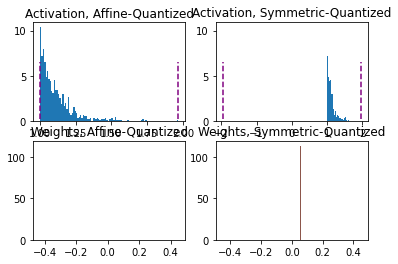

In [4]:
from matplotlib import pyplot as plt
import numpy as np


def get_symmetric_range(x):
    '''获取对称范围'''
    beta = torch.max(x.max(), x.min().abs())
    return -beta.item(), beta.item()


def get_affine_range(x):
    '''获取仿射范围'''
    return x.min().item(), x.max().item()


def plot(plt, data, scheme):
    '''画出不同方案的分布'''
    boundaries = get_affine_range(data) if scheme == 'affine' \
        else get_symmetric_range(data)
    a, _, _ = plt.hist(data, density=True, bins=100)
    ymin, ymax = np.quantile(a[a > 0], [0.25, 0.95])
    plt.vlines(x=boundaries, ls='--', colors='purple', ymin=ymin, ymax=ymax)


# 模拟激活和权重
act = torch.distributions.pareto.Pareto(1, 10).sample((1, 1024))
weights = torch.distributions.normal.Normal(0, 0.12).sample((3, 64, 7, 7)).flatten()

fig, axs = plt.subplots(2, 2)
plot(axs[0, 0], act, 'affine')
axs[0, 0].set_title("Activation, Affine-Quantized")
plot(axs[0, 1], act, 'symmetric')
axs[0, 1].set_title("Activation, Symmetric-Quantized")
plot(axs[1, 0], weights, 'affine')
axs[1, 0].set_title("Weights, Affine-Quantized")
plot(axs[1, 1], weights, 'symmetric')
axs[1, 1].set_title("Weights, Symmetric-Quantized")
plt.show()


在 PyTorch 中，你可以在初始化 `Observer` 时指定仿射或对称模式。注意，并非所有 `observer` 都支持这两种方案。

In [5]:
for qscheme in [torch.per_tensor_affine, torch.per_tensor_symmetric]:
    obs = MovingAverageMinMaxObserver(qscheme=qscheme)
    for x in inputs: obs(x)
    print(f"Qscheme: {qscheme} | {obs.calculate_qparams()}")

Qscheme: torch.per_tensor_affine | (tensor([0.0072]), tensor([88], dtype=torch.int32))
Qscheme: torch.per_tensor_symmetric | (tensor([0.0094]), tensor([128]))


## 逐张量和逐通道量化方案

量化参数可以作为整体计算层的整个权值张量，也可以单独计算每个通道的权值张量。在每张量中，对层中的所有通道应用相同的剪切范围：

![](images/tensor-quantization.png)

对于权值量化，逐通道（Per-Channel）对称量化提供了更好的精度；逐张量（Per-Tensor）量化的性能很差，这可能是由于不同通道之间的转换权值与批量范数折叠（batchnorm folding） {cite:ps}`wu2020integer` 差异很大。

In [6]:
from torch.ao.quantization.observer import MovingAveragePerChannelMinMaxObserver
# 计算全部 `C` 通道的 qparams
obs = MovingAveragePerChannelMinMaxObserver(ch_axis=0)
for x in inputs: obs(x)
print(obs.calculate_qparams())

(tensor([0.0031, 0.0024, 0.0054]), tensor([200,  64,  34], dtype=torch.int32))


## 后端引擎

目前，量化算子通过 [FBGEMM 后端](https://github.com/pytorch/FBGEMM) 在 x86 机器上运行，或者在 ARM 机器上使用 [QNNPACK](https://github.com/pytorch/QNNPACK) 原语。服务器 GPU 的后端支持（通过 TensorRT 和 cuDNN）即将推出。了解更多关于将量化扩展到自定义后端：[RFC-0019](https://github.com/pytorch/rfcs/blob/master/RFC-0019-Extending-PyTorch-Quantization-to-Custom-Backends.md)。

In [7]:
from torch.ao.quantization.qconfig import get_default_qconfig
backend = 'fbgemm' # if x86 else 'qnnpack'
qconfig = get_default_qconfig(backend)  
torch.backends.quantized.engine = backend

## `QConfig`

{class}`~torch.ao.quantization.qconfig.QConfig` NamedTuple 存储用于量化激活和权重的 Observer 和量化方案。

一定要传递 `Observer` 类（而不是实例），或者可以返回 `Observer` 实例的可调用对象。使用 {func}`with_args` 覆盖默认参数。

In [8]:
from torch.ao.quantization.qconfig import QConfig

my_qconfig = QConfig(
  activation=MovingAverageMinMaxObserver.with_args(qscheme=torch.per_tensor_affine),
  weight=MovingAveragePerChannelMinMaxObserver.with_args(qscheme=torch.qint8)
)

In [11]:
my_qconfig

QConfig(activation=functools.partial(<class 'torch.ao.quantization.observer.MovingAverageMinMaxObserver'>, qscheme=torch.per_tensor_affine){}, weight=functools.partial(<class 'torch.ao.quantization.observer.MovingAveragePerChannelMinMaxObserver'>, qscheme=torch.qint8){})

## 在 PyTorch 中

PyTorch 允许您使用几种不同的方式来量化您的模型：

- Eager 模式 v/s FX Graph 模式：如果你更喜欢灵活但手动的，或受限的自动过程
- 静态 v/s 动态：如果量化激活（层的输出）的 `qparams` 为所有输入预先计算，或对每个输入重新计算，
- 量化感知训练（quantization-aware training） v/s 训练后量化（post-training quantization）：如果 `qparams` 是在有或没有重新训练的情况下计算的

FX Graph Mode 自动融合符合条件的模块，插入 Quant/DeQuant stub，校准模型并返回量化模块——所有这些都是在两个方法调用中进行的——但仅适用于 [可符号跟踪](https://pytorch.org/docs/stable/fx.html#torch.fx.symbolic_trace) 的网络。 

在 DNN 中，量化的合适候选对象是 FP32 权值（层参数）和激活（层输出）。量化权值可以减少模型的大小。量化激活通常会导致更快的推理。

例如，50 层 ResNet 网络有近 2600 万个权值参数，在正向传程中计算近 1600 万个激活。

### Post-Training Dynamic/Weight-only Quantization

这里模型的权值是预量化的；在推理期间，激活是动态量化的。这是所有方法中最简单的一种，它在 {func}`~torch.ao.quantization.quantize.quantize_dynamic` 中有一行 API 调用。目前只支持线性和循环（LSTM、GRU、RNN）层进行动态量化。

- 可以导致更高的精度，因为每个输入的裁剪范围是精确校准的
- 对于像 LSTM 和 Transformer 这样的模型，动态量化是首选的，因为从内存中写入/检索模型的权值会受制于带宽
- 在运行时对每个层的激活进行校准和量化会增加计算开销。

In [1]:
import torch
from torch import nn

# 小 model
def create_model():
  m = nn.Sequential(
  nn.Conv2d(2, 64, (8,)),
  nn.ReLU(),
  nn.Linear(16,10),
  nn.LSTM(10, 10))

  m.eval()
  return m

```{rubric} eager 模式
```

In [2]:
from torch.ao.quantization.quantize import quantize_dynamic

m = create_model()
model_quantized = quantize_dynamic(
    model=m, qconfig_spec={nn.LSTM, nn.Linear}, dtype=torch.qint8, inplace=False
)

```{rubric} FX 模式
```

In [3]:
from torch.ao.quantization import quantize_fx
from torch.ao.quantization.qconfig import default_dynamic_qconfig

m = create_model()
# 空键表示应用于所有模块的默认值
qconfig_dict = {"": default_dynamic_qconfig}
model_prepared = quantize_fx.prepare_fx(m, qconfig_dict)
model_quantized = quantize_fx.convert_fx(model_prepared)

/home/pc/xinet/anaconda3/envs/torchx/lib/python3.10/site-packages/torch/ao/quantization/fx/quantization_patterns.py:630: UserWarning: dtype combination: (torch.float32, torch.qint8, torch.quint8) is not supported by Conv supported dtype combinations are: [(torch.quint8, torch.qint8, None)]
  warnings.warn(


### Post-Training Static Quantization (PTQ)

PTQ 也预量化模型权重，但不是动态校准激活，而是使用验证数据对剪切范围进行预校准和固定（“静态”）。在推理过程中，激活在运算之间保持量化精度。大约 100 个小批次的代表性数据就足以校准观测者。为了方便起见，下面的例子在校准中使用了随机数据——在应用程序中使用随机数据将导致错误的 `qparams`。

![](images/ptq-flowchart.svg)

[模块融合](https://pytorch.org/tutorials/recipes/fuse.html) 将多个顺序模块（如：`[Conv2d, BatchNorm, ReLU]`）组合成一个。融合模块意味着编译器只需要运行一个内核而不是多个；这可以通过减少量化误差来提高速度和准确性。

- 静态量化比动态量化具有更快的推理速度，因为它消除了层之间的 float<->int 转换成本。
- 静态量化模型可能需要定期重新校准，以保持对分布漂移的鲁棒性。

静态量化模型包括以下步骤：

- 融合模块
- 插入 Quant/DeQuant 存根
- 准备融合模块（在层前和层后插入观察者）
- 校准准备好的模块（传递代表数据）
- 转换校准模块（替换为量化版本）

In [ ]:
from torch.quantization import quantize_fx
import torch
from torch import nn

backend = "fbgemm"  # 运行在x86 CPU 上。如果在ARM上运行，使用“qnnpack”。

m = nn.Sequential(
    nn.Conv2d(2, 64, 3),
    nn.ReLU(),
    nn.Conv2d(64, 128, 3),
    nn.ReLU()
)

#### 急切的模式

**融合**：就地融合用所述融合模块替换所述序列中的第一个模块，其余用相同模块替换。

In [ ]:
# fuse first Conv-ReLU pair
torch.quantization.fuse_modules(m, ['0', '1'], inplace=True)
# fuse second Conv-ReLU pair
torch.quantization.fuse_modules(m, ['2', '3'], inplace=True)

插入 stub：

In [ ]:
m = nn.Sequential(torch.quantization.QuantStub(),
                  *m,
                  torch.quantization.DeQuantStub())

准备：

In [ ]:
m.qconfig = torch.quantization.get_default_qconfig(backend)
torch.quantization.prepare(m, inplace=True)

**校准**：为了方便起见，这个例子使用了随机数据。使用代表性（验证）数据代替。

In [ ]:
# with torch.inference_mode(): # PyTorch 1.9
with torch.no_grad():
    for _ in range(10):
        x = torch.rand(1, 2, 28, 28)
        m(x)

转换：

In [ ]:
torch.quantization.convert(m, inplace=True)

检查：

In [ ]:
# 1 字节，而不是 FP32 的 4 字节
print(m[1].weight().element_size())

#### FX GRAPH

```python
from torch.quantization import quantize_fx
m.eval()
qconfig_dict = {"": torch.quantization.get_default_qconfig(backend)}
# 准备
model_prepared = quantize_fx.prepare_fx(model_to_quantize, qconfig_dict)
# Calibrate - Use representative (validation) data.
with torch.inference_mode():
  for _ in range(10):
    x = torch.rand(1,2,28, 28)
    model_prepared(x)
# quantize
model_quantized = quantize_fx.convert_fx(model_prepared)
```

### Quantization-aware Training (QAT)

![](images/qat-flowchart.svg)

PTQ 方法对于大型模型非常好，但在较小的模型中准确性会受到影响。当然，这是由于将 FP32 的模型调整到 INT8 域时的数值精度损失。

QAT 通过在训练损失中包含量化误差来解决这个问题，因此训练一个 INT8-first 模型。

![](images/ptq-qat.png)

所有的权重和偏置都存储在 FP32 中，反向传播照常发生。然而在正向传递中，量化是通过 `FakeQuantize` 模块进行内部模拟的。它们之所以被称为假的，是因为它们对数据进行量化和立即反量化，并添加与量化推理过程中可能遇到的类似的量化噪声。因此，最终的损失可以解释任何预期的量化误差。在此基础上进行优化，可以使模型在损失函数中识别出更宽的区域，并识别出 FP32 参数，这样量化到 INT8 不会显著影响精度。

[![](images/qat-fake-quantization.png)](https://developer.nvidia.com/blog/achieving-fp32-accuracy-for-int8-inference-using-quantization-aware-training-with-tensorrt)

- QAT 比 PTQ 具有更高的精度。
- Qparams 可以在模型训练期间学习，以获得更细粒度的准确性（参见 [LearnableFakeQuantize](https://github.com/pytorch/pytorch/blob/master/torch/ao/quantization/_learnable_fake_quantize.py)）。
- 在 QAT 中，重新训练一个模型的计算成本可以达到几百个 epoch。{cite:ps}`gholami2021survey`

除了在将模型实际转换为量化版本之前的训练循环之外，QAT 遵循与 PTQ 相同的步骤：

In [ ]:
import torch
from torch import nn

# 运行在 x86 CPU 上。如果在 ARM 上运行，使用 "qnnpack"。
backend = "fbgemm"  

m = nn.Sequential(
    nn.Conv2d(2, 64, 8),
    nn.ReLU(),
    nn.Conv2d(64, 128, 8),
    nn.ReLU()
)

融合：

In [ ]:
torch.quantization.fuse_modules(m, ['0','1'], inplace=True) # 融合第一对 Conv-ReLU
torch.quantization.fuse_modules(m, ['2','3'], inplace=True) # 融合第二对 Conv-ReLU

插入存根（打桩）：

In [ ]:
m = nn.Sequential(torch.quantization.QuantStub(),
                  *m,
                  torch.quantization.DeQuantStub())

准备：

In [ ]:
m.train()
m.qconfig = torch.quantization.get_default_qconfig(backend)
torch.quantization.prepare_qat(m, inplace=True)

循环训练：

In [ ]:
n_epochs = 10
opt = torch.optim.SGD(m.parameters(), lr=0.1)
def loss_fn(out, tgt): return torch.pow(tgt-out, 2).mean()


for epoch in range(n_epochs):
  x = torch.rand(10, 2, 24, 24)
  out = m(x)
  loss = loss_fn(out, torch.rand_like(out))
  opt.zero_grad()
  loss.backward()
  opt.step()

转换：

In [ ]:
m.eval()
torch.quantization.convert(m, inplace=True)

## 敏感性分析

并不是所有层对量化的响应都是一样的，有些层对精度下降比其他层更敏感。确定最优的层组合以最小化精度下降是非常耗时的，因此 {cite:ps}`wu2020integer` 建议进行一次一次的灵敏度分析，以确定哪些层最敏感，并在这些层上保持 FP32 的精度。在他们的实验中，跳过 2 个 conv 层（在 MobileNet v1 的 28 个 conv 层中）使他们接近 FP32 的精度。使用 FX Graph 模式，可以创建自定义 `qconfigs` 来轻松做到这一点。

```python
# ONE-AT-A-TIME SENSITIVITY ANALYSIS 

for quantized_layer, _ in model.named_modules():
  print("Only quantizing layer: ", quantized_layer)

  # The module_name key allows module-specific qconfigs. 
  qconfig_dict = {"": None, 
  "module_name":[(quantized_layer, torch.quantization.get_default_qconfig(backend))]}

  model_prepared = quantize_fx.prepare_fx(model, qconfig_dict)
  # calibrate
  model_quantized = quantize_fx.convert_fx(model_prepared)
  # evaluate(model)
```

另一种方法是比较 FP32 和 INT8 层的统计数据；常用的度量有 SQNR（信号量化噪声比，即 Signal to Quantized Noise Ratio）和均方误差（Mean-Squre-Error）。这种比较分析也有助于指导进一步的优化。

![](images/compare_output_ns.png)

PyTorch 在数值套件下提供了帮助进行此分析的工具。从完整的教程中了解更多关于使用 [Numeric Suite](https://pytorch.org/tutorials/prototype/numeric_suite_tutorial.html) 的信息。

```python
# extract from https://pytorch.org/tutorials/prototype/numeric_suite_tutorial.html
import torch.quantization._numeric_suite as ns

def SQNR(x, y):
    # Higher is better
    Ps = torch.norm(x)
    Pn = torch.norm(x-y)
    return 20*torch.log10(Ps/Pn)

wt_compare_dict = ns.compare_weights(fp32_model.state_dict(), int8_model.state_dict())
for key in wt_compare_dict:
    print(key, compute_error(wt_compare_dict[key]['float'], wt_compare_dict[key]['quantized'].dequantize()))

act_compare_dict = ns.compare_model_outputs(fp32_model, int8_model, input_data)
for key in act_compare_dict:
    print(key, compute_error(act_compare_dict[key]['float'][0], act_compare_dict[key]['quantized'][0].dequantize()))
```

## 对您工作流程的建议

![](images/quantization-flowchart2.png)

要点：

- 大（10M+ 参数）模型对量化误差更具鲁棒性。
- 从 FP32 检查点量化模型比从零开始训练 INT8 模型提供了更好的 accuracy。
- 分析模型运行时是可选的，但它可以帮助识别阻碍推理的层。
- 动态量化是一个简单的第一步，特别是当您的模型有许多线性或递归层时。
- 使用逐通道对称量化借由 `MinMax` 观测者量化权重。使用逐张量仿射量化借由 `MovingAverageMinMax` 观测者量化激活。
- 使用诸如 SQNR 之类的度量来确定哪些层最容易受到量化误差的影响。关闭这些层上的量化。
- 使用 QAT 对原始训练调度的大约 $10\%$ 进行微调，退火学习率（annealing learning rate）调度从初始训练学习率的 $1\%$ 开始。
- 如果上面的工作流程不适合你，我们想知道更多。发布一个包含你的代码细节的帖子（模型架构，准确性指标，尝试过的技术）。请抄送 [@suraj.pt](https://discuss.pytorch.org/u/suraj.pt/)。